# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [ ]:
import json
import sys
sys.path.append('../..')

from utils import validateJson

jsonData = json.load(open('recipes_valid.json'))
#validateJson.validateRecimeJson(jsonData)

print(jsonData.keys())

dict_keys(['title', 'ingredients', 'instructions'])


In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/'
import sys
sys.path.append(dataPath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
dataPath = 'data/'

In [2]:
import pickle
import pandas as pd

with open(dataPath + 'recipes_valid.pkl', 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())

Index(['title', 'ingredients', 'instructions'], dtype='object')


In [192]:
def oneHotEncoding(values: pd.DataFrame, dictionary: dict) -> pd.DataFrame:
    embedding = np.zeros((values.shape[0], len(dictionary)))

    oneHotCols = []
    for index, value_index in enumerate(values.index):
        embedding[index][dictionary[values[value_index]]-1] = 1
        oneHotCols += [value_index + '_' + str(key) for key in dictionary.keys()]

    oneHotEmb = embedding.flatten()

    return pd.DataFrame(oneHotEmb, oneHotCols).T

In [248]:
import word2vec
import numpy as np

def preProcessInput(ds: pd.Series):
    assert('ingredients' == ds.name)
    assert 'amount' in ds.iloc[0].columns, "Column Amount not found in Dataframe"
    assert 'unit' in ds.iloc[0].columns, "Column Unit not found in Dataframe"
    assert 'ingredient' in ds.iloc[0].columns, "Column Ingredient not found in Dataframe"

    # Todo: Move to constructor one functions is done
    w2v_model = word2vec.load('data/vocab.bin')
    ingredientDict = {}
    for voc in w2v_model.vocab:
        # Offset by 1 so empty fields can be 0
        ingredientDict.setdefault(voc, len(ingredientDict)+1)

    # Unit dict will still be necessary for the one hot encoding
    unitDict = {}
    for df in ds:
        for unit in df['unit']:
            # Offset by 1 so empty fields can be 0
            unitDict.setdefault(unit, len(unitDict)+1)

    outputList = []

    for df in ds:
        # Split amounts, units, ingredients and convert to single row
        amounts = df['amount'].append(pd.Series([0.0] * (20-len(df))), ignore_index = True).T.add_prefix('amount')


        # Convert units to one hot encoded single row
        # Single row:
        unitValues = df['unit'].append(pd.Series([""] * (20-len(df))), ignore_index = True).T.add_prefix('unit')
        # One-Hot Encoded single row:
        units = oneHotEncoding(unitValues, unitDict)

        # Maybe embedd first and convert to single row afterwards
        ingredients = df['ingredient'].append(pd.Series([""] * (20-len(df))), ignore_index = True).T.add_prefix('ingredient')

        # Do embedding for integer encoded ingredients convert to single row
        # Replace spaces with underscores else no mapping can be found in the dict
        # Load vocab.txt (or vocab.bin) + create dict --> integer encode ingredients of the current recipe
        ingr = pd.Series().reindex_like(ingredients).fillna(0)
        for ingred in ingredients.index:
            # preferably use last part of the ingredient, some are not available in the dict
            name_words = ingredients[ingred].lower().split(' ')
            for i in range(len(name_words)):
                name_ind = dict.get('_'.join(name_words[i:]))
                if name_ind:
                    ingr[ingred] = name_ind
        
        weights = torch.FloatTensor(w2v_model.vectors)
        emb = torch.nn.Embedding.from_pretrained(weights)
        ingr_tensor = torch.LongTensor(ingr.values.astype('int32'))
        ingr_emb = emb(ingr_tensor)

        ingrOut = []
        for index in range(0,ingr_emb.shape[0]):
            ingrOut += ingr_emb[index][:]


        # Sort + concat amounts, units, ingredients (as df with corrent row names -> If embedded this is not possible + useless)
        # Sorting is ignored for now

        amounts = amounts.values.astype('float32')
        units = units.values[0].astype('float32')
        ingreds = np.asarray(ingrOut).astype('float32')
        out = np.concatenate((amounts, units, ingreds))
        # Append output df
        outputList.append(out)

    return outputList

out = preProcessInput(pklData['ingredients'])

/opt/anaconda3/envs/recime_new/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/anaconda3/envs/recime_new/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/anaconda3/envs/recime_new/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/anaconda3/envs/recime_new/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warni

In [250]:
print(len(out))
print(len(out[0]))

6700

In [229]:
amount = amounts.values.astype('float32')
print(amount.shape)
unit = units.values[0].astype('float32')
print(unit.shape)
ingr = np.asarray(ingrOut).astype('float32')
print(ingr.shape)
out = np.concatenate((amount, unit, ingr))
out.shape

(20,)
(680,)
(6000,)


(6700,)

In [173]:
ingr = un.copy()
ingr.loc[ingr == ""] = 0
for ingred in un.index:
    # preferably use last part of the ingredient, some are not available in the dict
    name_words = un[ingred].lower().split(' ')
    for i in range(len(name_words)):
        name_ind = dict.get('_'.join(name_words[i:]))
        if name_ind:
            ingr[ingred] = name_ind
            break

In [178]:
ingr.values.astype('uint16')

array([6634,   68,  372, 2795, 4340,  551,  294,   32, 4929,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=uint16)

In [185]:
w2v_model = word2vec.load('data/vocab.bin')
weights = torch.FloatTensor(w2v_model.vectors)

emb = torch.nn.Embedding.from_pretrained(weights)
ingr_tensor = torch.LongTensor(ingr.values.astype('int32'))
ingr_emb = emb(ingr_tensor)
ingrOut = []
for index in range(0,ingr_emb.shape[0]):
    ingrOut += ingr_emb[index][:]

6000

In [149]:
embedding = np.zeros((un.shape[0], len(dict)))

oneHotCols = []
for index, unit_index in enumerate(un.index):
    embedding[index][dict[un[unit_index]]-1] = 1
    oneHotCols += [unit_index + '_' + str(key) for key in dict.keys()]

oneHotEmb = embedding.flatten()

df = oneHotEncoding(un, dict)
df

KeyError: 'elbow macaroni'

## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [3]:
data = []

for recipeIndex, item in enumerate(pklData.iterrows()):
    rowData = {}
    for index, ingredient in item[1]['ingredients'].iterrows():
        for key in ingredient.keys():
            rowData[key+str(index)] = ingredient[key]
    data.append(rowData)
    if recipeIndex == 1000:
        break

frame = pd.DataFrame(data)
del data


In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce
from scipy import sparse
import numpy as np

dropColumns = []
for column in frame.columns:
    if 'amount' in column:
        dropColumns.append(column)
frameStripped = frame.drop(columns=dropColumns).astype("str")
frameStripped.fillna(0)


#del pklData

frameStripped_cols = frameStripped.columns

frameStripped_np = frameStripped.to_numpy()
frameStripped_cols_np = frameStripped_cols.astype("str").to_numpy()

enc = OneHotEncoder()
enc.fit(frameStripped)
sparseStrippedEncodedFrame = enc.transform(frameStripped)
sparseStrippedEncodedFrame_cols = enc.get_feature_names_out(frameStripped_cols)

sparseDroppedFrame = sparse.csr_matrix(frame[dropColumns])

sparseEncodedFrame = sparse.hstack([sparseDroppedFrame, sparseStrippedEncodedFrame])
sparseEncodedFrame_cols = [*dropColumns, *sparseStrippedEncodedFrame_cols]


## VAE
### Setup

In [5]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from cvae import VariationalAutoEncoder

# Import custom helper functions
from networkUtils import DataBuilder, CustomLoss, standardize_data, sparse_batch_collate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Setup Datasets + Hyperparameters

In [6]:
# One hot encoding without embedding and using sparse frame
train_data, test_data, scaler =  standardize_data(sparseEncodedFrame)
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(train_data, standardizer=scaler)
testdata_set=DataBuilder(test_data, standardizer=scaler)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size, collate_fn=sparse_batch_collate)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size, collate_fn=sparse_batch_collate)

TypeError: __init__() missing 1 required positional argument: 'matrix_str'

In [6]:
def collateFuncTuple(batch):
    print(type(batch))
    for item in batch:
        print(type(item))
        

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

In [9]:
# No encoding, using embedding instead!
from sklearn.model_selection import train_test_split
train_data_num, test_data_num, scaler =  standardize_data(frame[dropColumns])
train_data_str, test_data_str =  train_test_split(le.fit_transform(frameStripped), test_size=0.3, random_state=42)
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(train_data_num, train_data_str, standardizer=scaler)
testdata_set=DataBuilder(test_data_num, test_data_str, standardizer=scaler)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size, )
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size, )

ValueError: y should be a 1d array, got an array of shape (1001, 40) instead.

In [ ]:
D_in = testdata_set.x.shape[1]
H = 1024
H2 = 128
latent_dim = 32
model = VariationalAutoEncoder('embeddings.pt', D_in, H, H2, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

### Train Model

In [ ]:
epochs = 10
log_interval = 5
val_losses = []
train_losses = []
test_losses = []

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data, data_str in enumerate(trainloader):
        print(data.shape)
        data = data.to(device)
        data_str = data_str.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, x_emb = model(data, data_str)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, x_emb, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [ ]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar, x_emb = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, x_emb, mu, logvar)
            print(recon_batch)
            loss_itm = loss.item()
            test_loss += loss_itm
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [ ]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

2
2


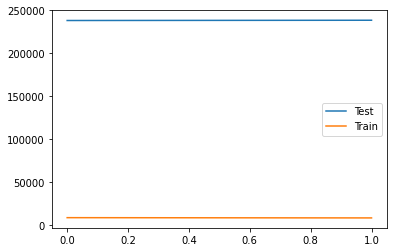

In [15]:
import matplotlib.pyplot as plt
print(len(test_losses))
print(len(train_losses))
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

### Draw random samples form latent space and generate new data

In [18]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [20]:
scaler = trainloader.dataset.standardizer

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data, columns = sparseEncodedFrame_cols)
df_fake.head(10)

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,unit19_cup,unit19_teaspoon,unit19_nan,ingredient19_almonds,ingredient19_basil,ingredient19_cracked black pepper,ingredient19_cumin seeds,ingredient19_nutmeg,ingredient19_parmesan cheese,ingredient19_nan
0,64.442848,23.664961,49.338566,-42.998547,-119.452202,-66.648613,-154.251694,-185.356903,-164.724823,-224.806580,...,-0.028250,-0.110497,1.084157,0.051840,-0.062902,-0.079490,0.061218,-0.060397,-0.051399,1.131299
1,8.810388,-47.286228,-2.823172,48.635700,-58.550415,-36.557465,-70.178871,-82.703217,-105.573212,-118.754425,...,-0.030345,-0.023925,1.025766,-0.028019,0.023379,-0.005964,-0.022965,0.003294,-0.025423,0.995447
2,-1.479209,55.904152,50.416714,16.045837,3.950845,-2.350046,-14.598464,30.940853,-32.246025,2.382841,...,0.018094,0.091752,0.900818,-0.014077,0.042977,0.029060,0.036929,0.044264,0.074645,0.890370
3,14.182304,2.477328,-3.760162,59.003902,28.163504,-46.981678,-35.794037,11.232952,-42.479977,-37.004219,...,0.012978,0.037571,0.931026,0.027492,0.004488,0.064478,0.022188,0.006302,-0.050789,0.944272
4,-4.144509,0.413773,-8.249460,-11.594110,-7.094406,-10.214097,-33.688137,-15.935955,-122.170860,-67.986969,...,-0.040827,-0.063641,1.004102,-0.053448,-0.001934,-0.022430,-0.049479,-0.019020,0.047482,1.051290
5,15.411857,-8.295390,-23.451984,29.268505,23.886280,-25.089275,27.983902,-41.818836,-19.926884,-6.036649,...,-0.020333,0.055510,1.012205,-0.017005,0.051237,0.049119,-0.020612,0.018022,0.000003,0.912954
6,24.510502,24.927975,-24.636230,4.046587,-88.699768,-59.342678,-70.648712,-126.234207,-101.880051,-116.562057,...,-0.042844,-0.089186,1.141565,-0.019712,-0.007393,-0.045219,-0.039125,-0.023895,-0.016758,1.142131
7,42.387592,-37.253128,6.229177,-42.571140,-3.960990,-30.770060,-16.483934,-75.723740,-73.279839,-75.188171,...,0.017235,-0.072167,1.145681,-0.027864,-0.052573,-0.026170,-0.012024,-0.001890,-0.025401,1.130188
8,-17.964615,22.236544,-20.761372,-12.459864,14.089928,-94.008537,14.994526,-2.091276,4.619711,-16.819242,...,-0.030637,0.046837,0.925529,-0.028139,0.007860,0.018159,0.017165,-0.004218,0.019962,0.963237
9,-68.803978,-6.645006,-95.787483,76.462791,27.749420,46.117683,35.983135,82.630394,-34.864960,-64.939857,...,-0.023369,0.005344,0.868697,-0.020859,0.010531,0.031010,-0.008310,0.010462,0.024492,0.916556


In [21]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped_cols)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,unit15,ingredient15,unit16,ingredient16,unit17,ingredient17,unit18,ingredient18,unit19,ingredient19
0,64.442848,23.664961,49.338566,-42.998547,-119.452202,-66.648613,-154.251694,-185.356903,-164.724823,-224.806580,...,NaN,NaN,NaN,cilantro,NaN,NaN,pound-mass,NaN,NaN,NaN
1,8.810388,-47.286228,-2.823172,48.635700,-58.550415,-36.557465,-70.178871,-82.703217,-105.573212,-118.754425,...,NaN,parsley,NaN,coriander seeds,NaN,NaN,NaN,cooked rice,NaN,NaN
2,-1.479209,55.904152,50.416714,16.045837,3.950845,-2.350046,-14.598464,30.940853,-32.246025,2.382841,...,NaN,fresh coriander,NaN,NaN,NaN,oranges,NaN,parsnips,NaN,NaN
3,14.182304,2.477328,-3.760162,59.003902,28.163504,-46.981678,-35.794037,11.232952,-42.479977,-37.004219,...,NaN,parsley,NaN,heavy cream,NaN,NaN,NaN,NaN,NaN,NaN
4,-4.144509,0.413773,-8.249460,-11.594110,-7.094406,-10.214097,-33.688137,-15.935955,-122.170860,-67.986969,...,NaN,red wine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,15.411857,-8.295390,-23.451984,29.268505,23.886280,-25.089275,27.983902,-41.818836,-19.926884,-6.036649,...,NaN,red snapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,24.510502,24.927975,-24.636230,4.046587,-88.699768,-59.342678,-70.648712,-126.234207,-101.880051,-116.562057,...,NaN,honey,NaN,NaN,NaN,kashmiri chili powder,pound-mass,NaN,NaN,NaN
7,42.387592,-37.253128,6.229177,-42.571140,-3.960990,-30.770060,-16.483934,-75.723740,-73.279839,-75.188171,...,NaN,fresh parsley,NaN,coriander seeds,NaN,NaN,NaN,NaN,NaN,NaN
8,-17.964615,22.236544,-20.761372,-12.459864,14.089928,-94.008537,14.994526,-2.091276,4.619711,-16.819242,...,NaN,red bell pepper,NaN,NaN,NaN,lemons,NaN,parsnips,NaN,NaN
9,-68.803978,-6.645006,-95.787483,76.462791,27.749420,46.117683,35.983135,82.630394,-34.864960,-64.939857,...,NaN,parmesan cheese,NaN,NaN,NaN,kashmiri chili powder,pound-mass,NaN,NaN,NaN


In [22]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[(2*index)+lenIngredients])
        frame.append(value[(2*index+1)+lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"[64.4428482055664, cubic centimetre, chocolate...","[23.664960861206055, , lavender]","[49.338565826416016, centimetre, fresh mushrooms]","[-42.9985466003418, teaspoon, potatoes]","[-119.45220184326172, nan, Coleslaw]","[-66.64861297607422, nan, grapefruit juice]","[-154.25169372558594, nan, evaporated milk]","[-185.35690307617188, quart, creole mustard]","[-164.72482299804688, nan, mustard powder]","[-224.80657958984375, nan, low - fat chunky pa...","[-191.13412475585938, nan, nan]","[-198.8765869140625, nan, gravy]","[-167.53050231933594, nan, white pepper]","[-147.92593383789062, nan, baking potatoes]","[-160.70291137695312, nan, nan]","[-145.7584991455078, nan, nan]","[-149.96124267578125, nan, cilantro]","[-128.2501220703125, nan, nan]","[-121.9117660522461, pound-mass, nan]","[-117.51127624511719, nan, nan]"
1,"[8.81038761138916, cubic centimetre, boneless ...","[-47.28622817993164, pint, chicken tenderloins]","[-2.823172092437744, pint, cinnamon schnapps]","[48.63570022583008, , tahini]","[-58.5504150390625, tonne, liquid smoke]","[-36.557464599609375, quart, bean sprouts]","[-70.17887115478516, nan, kidney beans]","[-82.70321655273438, nan, ground cumin]","[-105.57321166992188, nan, flat leaf parsley]","[-118.75442504882812, pint, rosemary sprigs]","[-113.6034927368164, nan, lemon]","[-139.75331115722656, nan, zucchini]","[-130.73011779785156, nan, jalapeno chiles]","[-109.12117767333984, nan, crusty bread]","[-126.45930480957031, nan, nan]","[-122.0693130493164, nan, parsley]","[-107.40736389160156, nan, coriander seeds]","[-106.6261978149414, nan, nan]","[-100.09082794189453, nan, cooked rice]","[-105.52842712402344, nan, nan]"
2,"[-1.4792094230651855, , pitted prunes]","[55.904151916503906, , calvados]","[50.41671371459961, , canola oil]","[16.04583740234375, cup, yellow cling peaches]","[3.9508450031280518, , rye flour]","[-2.350046157836914, tablespoon, ground walnuts]","[-14.598464012145996, tonne, reduced - sodium ...","[30.940853118896484, quart, black licorice]","[-32.24602508544922, tablespoon, prunes]","[2.3828413486480713, , remoulade sauce]","[-15.422608375549316, , dry mustard]","[15.704808235168457, , basil]","[-45.11494827270508, , corn kernels]","[-59.557708740234375, nan, blueberries]","[-61.270484924316406, nan, mozzarella cheese]","[-75.70954132080078, nan, fresh coriander]","[-72.7451171875, nan, nan]","[-78.82942199707031, nan, oranges]","[-80.99940490722656, nan, parsnips]","[-83.17864227294922, nan, nan]"
3,"[14.182304382324219, cubic centimetre, yellow ...","[2.477327823638916, litre, coconut milk]","[-3.760161876678467, tablespoon, yellow onions]","[59.003902435302734, tablespoon, ground fennel]","[28.163503646850586, , paprika]","[-46.9816780090332, tonne, celery seeds]","[-35.794036865234375, litre, lowfat mozzarella...","[11.232952117919922, , pumpernickel bread]","[-42.479976654052734, , boneless skinless salm...","[-37.00421905517578, , creme fraiche]","[-30.61975860595703, , corn]","[-90.59840393066406, pint, chicken stock]","[-84.19925689697266, nan, confectioners' sugar]","[-66.14666748046875, nan, red wine vinegar]","[-57.37556838989258, nan, hot dogs]","[-95.26604461669922, nan, parsley]","[-113.85942077636719, nan, heavy cream]","[-91.63735961914062, nan, nan]","[-99.84430694580078, nan, nan]","[-90.85391998291016, nan, nan]"
4,"[-4.1445088386535645, ounce, French haricots v...","[0.4137726426124573, , white tequila]","[-8.249460220336914, centimetre, pebbles]","[-11.594110488891602, cup, red grapefruit]","[-7.0944061279296875, tablespoon, minced ginger]","[-10.214097023010254, kilogram, barbecue sauce]","[-33.68813705444336, tonne, white vinegar]","[-15.935955047607422, tonne, heavy cream]","[-122.17086029052734, nan, assorted fresh vege...","[-67.98696899414062, pint, fresh gingerroot]","[-103.6115951538086, nan, canned black beans]","[-96.7330093383789, nan, black pepper]","[-89.1006088256836, nan, confectioners' sugar]","[-12